<a href="https://colab.research.google.com/github/YanivAmir/stock-predicition-CNN/blob/main/stock_image_generation_based_on_historical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
!pip install yahoo_fin
!pip install mplfinance

### Imports

In [2]:
from tvDatafeed import TvDatafeed, Interval #pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
import yfinance as yf
import yahoo_fin.stock_info as si
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import mplfinance as mpf
from datetime import datetime
from collections import Counter
import pandas as pd #pip install pandas==1.3.0
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import logging
import re
import seaborn as sns
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import warnings
import time
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data upload
Data is historic 1hr period stock price of ~6K stocks, downloaded from TradingView. Stocks contains a maximum of 5000 data points, each. Data was downloaded on a four-day period on the 17-20th of Sept 2024.

In [3]:
savePath ='/content/drive/MyDrive/myStocksSept2024/'
with open(savePath+'TVstockData_NASDAQ_all_4803_18-20Sept2024.pickle', 'rb') as file:
        nasdaq_data = pd.read_pickle(file)
with open(savePath+'TVstockData_NYSE_all_6293_17Sept2024.pickle', 'rb') as file:
        nyse_data = pd.read_pickle(file)
data = { **nasdaq_data,**nyse_data}
print(f'Total number of stocks {len(data)}')

Total number of stocks 5850


Data arranged as dfs in dictionaries, tickers as keys. Not all keys in the lists below are in the data, most discontinued stocks were removed.

In [4]:
nyse_tickers = si.tickers_other()
nasdaq_tickers = si.tickers_nasdaq()
tickers = nasdaq_tickers + nyse_tickers
data[tickers[1]].head()

,symbol,open,high,low,close,volume,cap,wide_range,narrow_range/wide_range
datetime,,,,,,,,,
2021-09-27 16:30:00,NASDAQ:AADI,31.45,31.450,31.09,31.090,1200.0,37308.0,0.011447,1.000000
2021-09-27 18:30:00,NASDAQ:AADI,31.00,31.000,30.60,30.600,1019.0,31181.4,0.012903,1.000000
2021-09-27 19:30:00,NASDAQ:AADI,30.30,30.300,30.10,30.155,500.0,15077.5,0.006601,0.725000
2021-09-27 20:30:00,NASDAQ:AADI,30.16,30.355,30.16,30.300,400.0,12120.0,0.006466,0.717949
2021-09-27 21:30:00,NASDAQ:AADI,30.30,30.300,30.30,30.300,260.0,7878.0,0.000000,0.000000


## Dates and MarketCap distributions of historical stock data

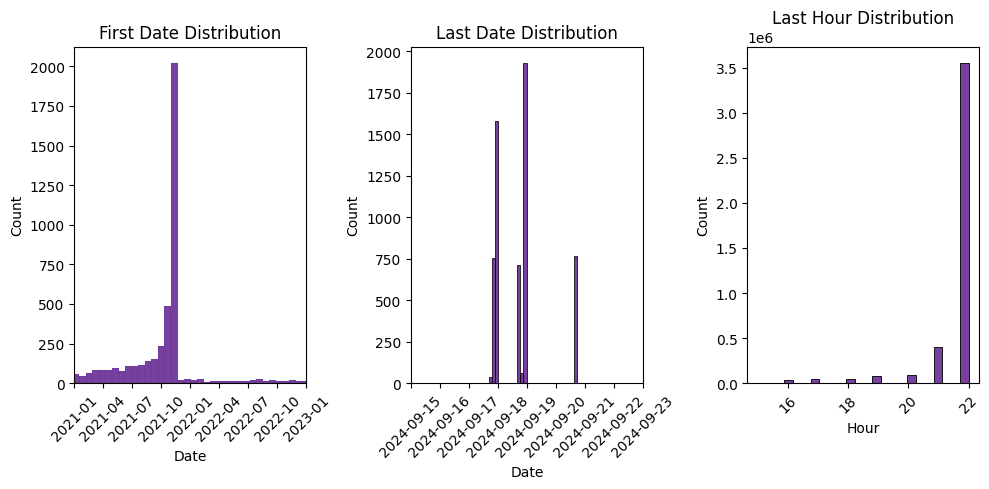

Dates less than mode date: 3716
Mode date: 2021-11-09
Count of mode date: 834
min date = 2000-06-22 22:30:00
max date = 2024-09-18 16:30:00


In [4]:
fig,ax = plt.subplots(1,3,figsize=(10,5))
firstDates= [data[k].index[0] for k in data]
lastDates= [data[k].index[-1] for k in data]
lastHours = []
for k,v in data.items():
  lastHours+=v.groupby(v.index.date).tail(1).index.hour.tolist()

lengths = [len(data[k]) for k in data]
#lasthour = [day.hour for day in data.index.get_level_values('datetime')]
sns.histplot(firstDates, ax = ax[0],color = 'indigo')
sns.histplot(lastDates, ax = ax[1],color = 'indigo')
sns.histplot(lastHours, ax = ax[2],color = 'indigo')
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)
ax[0].set_title('First Date Distribution')
ax[1].set_title('Last Date Distribution')
ax[2].set_title('Last Hour Distribution')
ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
ax[2].set_xlabel('Hour')
ax[0].set_xlim((datetime(2021,1,1),datetime(2023,1,1)))
ax[1].set_xlim((datetime(2024,9,15),datetime(2024,9,23)))
plt.tight_layout()
plt.show()

# Find the most common firstdate
date_counts = Counter([dt.date() for dt in firstDates])
mode_date, mode_count = date_counts.most_common(1)[0]
count_less_than_mode = sum([1 for date in firstDates if date.date() < mode_date])
print("Dates less than mode date:", count_less_than_mode)
print("Mode date:", mode_date)
print("Count of mode date:", mode_count)
print(f'min date = {min(firstDates)}')
print(f'max date = {max(firstDates)}')


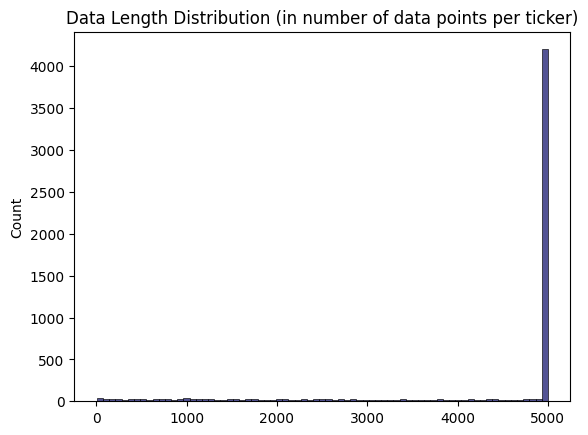

In [5]:
ax = sns.histplot(lengths, color = 'midnightblue')
ax.set_title('Data Length Distribution (in number of data points per ticker)')
plt.show()

In [7]:
lengths = []
capDayMean = []
capHrMean = []
shortTickers=[]
# Assuming data[ticker] is a DataFrame with a DateTimeIndex
start_date = datetime(2021, 11, 9).date()
end_date = datetime(2024, 9, 17).date()

# Filter the DataFrame based on the date range
for i,ticker in enumerate(data):
  #data[ticker] = data[ticker][(data[ticker].index.date >= start_date) & (data[ticker].index.date <= end_date)]
  lengths.append(len(data[ticker]))
  if lengths[-1]<2500:
    shortTickers.append(ticker)
  else:
    capDayMean.append(data[ticker].cap.resample('D').sum().mean())
    capHrMean.append(data[ticker].cap.mean())
  if i%500==0:
    print(i,end=' ')

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 

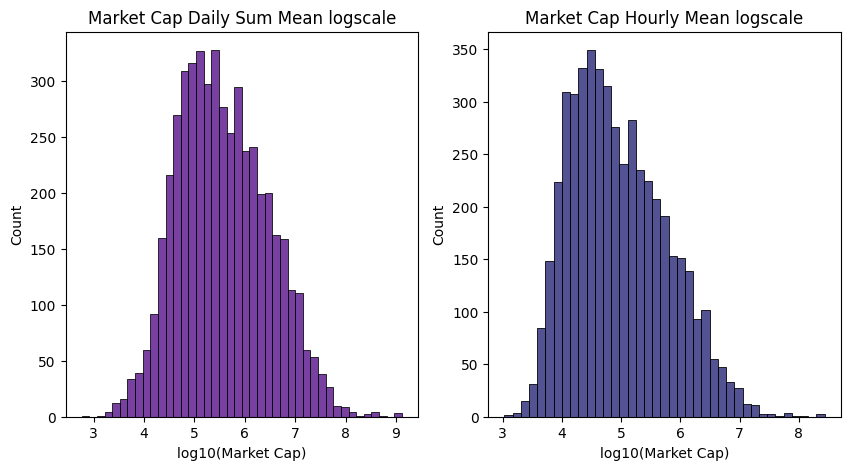

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(np.log10(capDayMean), ax = ax[0],color='indigo')
sns.histplot(np.log10(capHrMean), ax = ax[1],color='midnightblue')
ax[0].set_title('Market Cap Daily Sum Mean logscale')
ax[1].set_title('Market Cap Hourly Mean logscale')
ax[0].set_xlabel('log10(Market Cap)')
ax[1].set_xlabel('log10(Market Cap)')
plt.show()

Filtering data on basis of:

1.   Number of time points = at least 90% of expected
2.   Average Hourly Marketcap of at least 14K (~100K daily)
3.   Average Daily Marketcap of atleat 100K

In [5]:
positiveTickers = [ticker for ticker in data if len(data[ticker])>4500 and np.log10(data[ticker].cap.mean())>4.15 and np.log10(data[ticker].cap.resample('D').sum().mean())>5]
print(f'Ratio of Filtered data = {round(len(positiveTickers)/len(data),3)}')
print(f'Total number of stocks after filtering : {len(positiveTickers)}')

Ratio of Filtered data = 0.567
Total number of stocks after filtering : 3316


## Generating plots of historical price movement including marketcap:

*   each plor range is a period of 12 weeks
*   the target timepoint is 2 weeks after the end of the plot range
*   ranges start and end on Friday at 22:30
*   images are taken at a 1 week intervals
*   100 plots of candlesticks and marketcap are generated for each ticker




In [6]:
def saveData(saveStrt,saveEnd,candlesticksImgs,capImgs,targetsData):
  for data,dataName in zip([candlesticksImgs,capImgs,targetsData],['CandlesticksImgs','CapImgs','TargetsData']):
    np.savez_compressed(savePath+dataName+'_asList_'+str(saveStrt)+'-'+str(saveEnd)+'_24Sept2024.npz', *data)
  return

def generatePlots(positiveTickers,strtIdx,endIdx,startStrideNumberCurrentTicker,startStrideNumberAllOther,saveEvery=3000):
  saveIdx = strtIdx

  fig1, ax1 = plt.subplots(figsize=figsize,dpi=dpi)
  fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)

  candlesticksImgs,capImgs,targetsData = [],[],[]
  start_time = time.time()

  for j,ticker in enumerate(positiveTickers[strtIdx:endIdx]):

    if j%20==0:
      print('\n')
    print(j,ticker,end='  ')

    df = data[ticker]

    #filter the datetimes for the last hour of every Friday
    fridaysDf = df[(df.index.dayofweek == 4) & (df.index >= start_date) & (df.index <= end_date)]
    fridaysDf.sort_index(inplace=True)
    lastHourFridaysDf= fridaysDf.loc[fridaysDf.groupby(fridaysDf.index.date).apply(lambda x: x.index.max())]

    # create the target vector
    targets = (lastHourFridaysDf.close[numWeeks2predict:].values / lastHourFridaysDf.close[:-numWeeks2predict].values)[numWeeks2plot:] - 1

    # Extract the volume data and corresponding dates
    volume_data = df.cap

   # check if previous run was interrupted and saved mid ticker
    if startStrideNumberCurrentTicker!=startStrideNumberAllOther :
      startStrideNumber = startStrideNumberCurrentTicker
      startStrideNumberCurrentTicker = startStrideNumberAllOther
    else :
      startStrideNumber = startStrideNumberAllOther

    # run through all possible strides in the historical data of the current ticker
    for i in range(startStrideNumber,nStrides4Ticker):
      try:

        plotRangeStartDate = lastHourFridaysDf.index[i]
        plotRangeEndDate = lastHourFridaysDf.index[i + numWeeks2plot]

        # scale the data
        scaledDf = df[plotRangeStartDate : plotRangeEndDate].iloc[:, 1:5]
        scaler = MinMaxScaler()
        scaledDf.iloc[:,:] = scaler.fit_transform(scaledDf.values)

        # the first opening value is set to 0.5
        priceFix = 0.5/scaledDf.iloc[0,0]
        scaledDf *= priceFix

        # Plot 1: candlestick chart without volume
        ax1.clear()
        mpf.plot(scaledDf,type='ohlc',ax=ax1,volume=False,style='classic',show_nontrading=True)

        ax1.axis('off')
        ax1.set_ylim(0.0,1.5)
        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_visible(False)
        [ax1.spines[side].set_visible(False) for side in ['top', 'bottom', 'left', 'right']]
        '''ax1.set_title(ticker+' '+str(i)+' '+str(count)+' '+str(round(target,2)))
        plt.show()'''

        # transform into a greyscale array
        fig1.canvas.draw()
        rgba_array = np.frombuffer(fig1.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
        candlesticksImgs.append( (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255)
        '''plt.imshow(grey_array,cmap='gray')'''

        # Plot 2: Volume Only (as Marketcap)
        ax2.clear()
        ax2.bar(df.cap[plotRangeStartDate : plotRangeEndDate].index, df.cap[plotRangeStartDate : plotRangeEndDate], color='black', width=0.75)
        ax2.set_ylim(0,np.max(df.cap[plotRangeStartDate : plotRangeEndDate]))
        '''ax2.set_title(int(np.max(df.cap[plotRangeStartDate:plotRangeEndDate])),fontsize=15)'''
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        [ax2.spines[side].set_visible(False) for side in ['top', 'bottom', 'left', 'right']]

        # transform into a greyscale array
        fig2.canvas.draw()
        rgba_array = np.frombuffer(fig2.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
        capImgs.append((0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255)
        '''plt.imshow(grey_array,cmap='gray')'''

        targetDate = lastHourFridaysDf.index[i + numWeeks2plot + numWeeks2predict]
        predictionClose = lastHourFridaysDf.close.values[numWeeks2plot + numWeeks2predict:][i]
        plotRangeClose = lastHourFridaysDf.close.values[numWeeks2plot : -numWeeks2predict][i]

        targetsData.append([ticker,plotRangeStartDate,plotRangeEndDate,targetDate,predictionClose,plotRangeClose,targets[i]])

        # save every N candlesticks+marketcap plots
        if len(capImgs)%saveEvery ==0:
          saveData(saveIdx,j+strtIdx,candlesticksImgs,capImgs,targetsData)
          saveIdx = j+strtIdx
          print('\n\n',len(capImgs),' images saved. Ticker number ',j+strtIdx,' , image number ',i,' . It took ',np.floor(time.time()-start_time),' secs\n')
          candlesticksImgs,capImgs,targetsData = [],[],[]
      except:
        print('\n\n couldnt save image #',i,' @',ticker,'\n')
        continue

  # final save
  saveData(saveIdx,j+strtIdx,candlesticksImgs,capImgs,targetsData)
  print('\nSaved and finished ',endIdx-strtIdx,' tickers. It took ',np.floor(time.time()-start_time),' secs')
  return targetsData,capImgs,candlesticksImgs

In [7]:
start_date = pd.Timestamp('2000-06-22')
end_date = pd.Timestamp('2024-09-18')
numWeeks2plot = 12
numWeeks2predict = 2
dpi = 72
figsize = (5, 5)
nStrides4Ticker = 100 #maximum number of strides for each 5000hr duration is 125. leaving the last 25 for testset

strtIdx = 0
endIdx = 500
startStrideNumberAllOther=0 # for training and validation the first image number is 0. for test data the first image number is 100.
startStrideNumberCurrentTicker=0 #change to last stride of last ticker saved if run was interrupted otherwise equal to startStrideNumberAllOther


In [ ]:
targetsData,capImgs,candlesticksImgs = generatePlots(positiveTickers,strtIdx,endIdx,startStrideNumberCurrentTicker,startStrideNumberAllOther,saveEvery=3000)



0 AAL  1 AAOI  2 AAON  

 couldnt save image # 63  @ AAON 

3 AAPL  4 AAXJ  5 ABCL  

 couldnt save image # 43  @ ABCL 

6 ABNB  7 ABOS  8 ABSI  

 couldnt save image # 2  @ ABSI 



In [17]:
pd.DataFrame(targetsData).head()


,0,1,2,3,4,5,6
0,AAPL,2021-11-12 22:30:00,2022-02-11 22:30:00,2022-02-25 22:30:00,164.88,168.40,-0.020903
1,AAPL,2021-11-19 22:30:00,2022-02-18 22:30:00,2022-03-04 22:30:00,163.21,167.38,-0.024913
2,AAPL,2021-11-26 22:30:00,2022-02-25 22:30:00,2022-03-11 22:30:00,154.73,164.88,-0.061560
3,AAPL,2021-12-03 22:30:00,2022-03-04 22:30:00,2022-03-18 21:30:00,163.98,163.21,0.004718
4,AAPL,2021-12-10 22:30:00,2022-03-11 22:30:00,2022-03-25 22:30:00,174.56,154.73,0.128159
